In relation to the Gujarati book (basic econometrics), answer question 22.25 pp 800: Table 22.7 gives data on three-month (TB3M) and six-month (TB6M) Treasury bill rates from January 1, 1982, to March 2008, for a total of 315 monthly observations. The data can be found on the textbook's website. to. Plot the two time series in the same diagram. What do you see? b. Do a formal unit root analysis to find out if these time series are stationary. c. Are the two time series cointegrated? How do you know? Show the necessary calculations. d. What is the economic meaning of cointegration in the present context? If the two series are not cointegrated, what are the economic implications? and. If you want to estimate a VAR model, say, with four lags of each variable, do you have to use the first differences of the two series or can you do the analysis in levels of the two series? Justify your answer.

## Funciones re-utilizables

In [3]:
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Reusable functions
# Function for unit root tests with interpretation
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series)
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')
    print("INTERPRETATION:")
    if adf_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be non-stationary")

    # KPSS Test
    kpss_result = kpss(series)
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')
    print("INTERPRETATION:")
    if kpss_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is non-stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be stationary")

# Function to find best ARIMA model with interpretation
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("INTERPRETATION:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")
    return best_order

# Plot detailed forecast with confidence intervals and interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = model.forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    forecast_index = range(len(series), len(series) + steps)

    plt.figure(figsize=(12,6))
    plt.plot(series, label=f'{name} Historical')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='pink',
                    alpha=0.3,
                    label='95% Confidence Interval')
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Print forecast values
    print(f"\n{name} Forecast Values (next 5 periods):")
    print(forecast[:5])

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean()
    print(f"\nForecast Interpretation for {name}:")
    print(f"Last observed value: {last_value:.2f}")
    print(f"Average forecast value: {mean_forecast:.2f}")
    print(f"Forecast change: {mean_forecast - last_value:.2f}")
    if mean_forecast > last_value:
        print("Trend: Upward forecast trend")
    elif mean_forecast < last_value:
        print("Trend: Downward forecast trend")
    else:
        print("Trend: Flat forecast trend")
    print(f"95% CI range at period {steps}: [{conf_int.iloc[-1, 0]:.2f}, {conf_int.iloc[-1, 1]:.2f}]")
    print("Interpretation: The wider the confidence interval, the less certain the forecast")

# Function to plot correlograms with interpretation
def plot_correlograms(series, name, lags=30):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title(f'ACF for {name}')
    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title(f'PACF for {name}')
    plt.tight_layout()
    plt.show()
    print(f"\nCorrelogram Interpretation for {name}:")
    print("  - ACF: Shows total correlation at each lag, including indirect effects")
    print("  - PACF: Shows direct correlation at each lag, controlling for earlier lags")
    print("  - Significant spikes outside the blue confidence interval suggest strong correlations")
    print("  - ACF decay pattern indicates potential ARIMA model orders")
    print("  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order")

# Cointegration test with interpretation
def cointegration_test(df, ticker_1, ticker_2):
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    print("\nJohansen Cointegration Test:")
    print(f"Trace statistic: {result.lr1}")
    print(f"Critical values (90%, 95%, 99%): {result.cvt}")
    print("INTERPRETATION:")
    for i in range(len(result.lr1)):
        if result.lr1[i] > result.cvt[i, 1]:
            print(f"  - r = {i}: Cointegration exists at 95% confidence level")
            print(f"    Trace statistic ({result.lr1[i]:.2f}) > 95% critical value ({result.cvt[i, 1]:.2f})")
        else:
            print(f"  - r = {i}: No cointegration at 95% confidence level")
            print(f"    Trace statistic ({result.lr1[i]:.2f}) <= 95% critical value ({result.cvt[i, 1]:.2f})")
    if result.lr1[0] > result.cvt[0, 1]:
        print(f"Conclusion: {ticker_1} and {ticker_2} are cointegrated - they share a long-run equilibrium relationship")
    else:
        print(f"Conclusion: No evidence of cointegration between {ticker_1} and {ticker_2}")


## Data extraction

In [4]:
df_3 = pd.read_excel("EF19.xlsx")["GS3M"]
df_6 = pd.read_excel("EF19.xlsx")["GS6M"]

df_3
df_6

,GS6M
0,13.90
1,14.81
2,13.83
3,13.87
4,13.13
...,...
229,4.89
230,4.44
231,3.99
232,3.74


Se observa que en realidad no son 315 observaciones, sino que 234. De igual manera, se continua con el análisis.

## 1. Plot the two time series in the same diagram. What do you see?

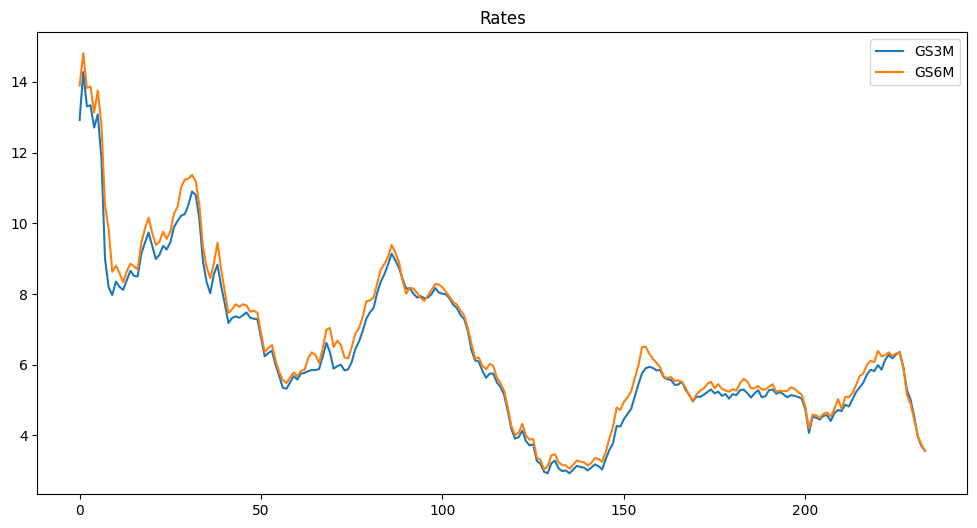

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df_3, label='GS3M')
plt.plot(df_6, label='GS6M')
plt.title('Rates')
plt.legend()
plt.show()

Se observa un desplazamiento conjunto muy marcado: los altos y bajos ocurren prácticamente al mismo tiempo y la brecha entre 3 y 6 meses es pequeña y relativamente estable (la de 6 meses suele ir ligeramente por encima). Es decir, los movimientos de corto plazo son muy parecidos y las dos curvas parecen estar gobernadas por la misma tendencia de fondo, lo que a priori sugiere una relación estrecha de largo plazo.

## Do a formal unit root analysis to find out if these time series are stationary

In [13]:
unit_root_tests(df_3, "GS3M")
unit_root_tests(df_6, "GS6M")


Unit Root Tests for GS3M:
ADF Test:
ADF Statistic: -1.5392
p-value: 0.5140
Critical Values: {'1%': np.float64(-3.460018927623594), '5%': np.float64(-2.8745897386146817), '10%': np.float64(-2.57372514086348)}
INTERPRETATION:
  - p-value >= 0.05: Fail to reject null - GS3M may be non-stationary

KPSS Test:
KPSS Statistic: 1.4540
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
INTERPRETATION:
  - p-value < 0.05: Reject null hypothesis - GS3M is non-stationary

Unit Root Tests for GS6M:
ADF Test:
ADF Statistic: -3.7738
p-value: 0.0032
Critical Values: {'1%': np.float64(-3.458854867412691), '5%': np.float64(-2.8740800599399323), '10%': np.float64(-2.573453223097503)}
INTERPRETATION:
  - p-value < 0.05: Reject null hypothesis - GS6M is stationary

KPSS Test:
KPSS Statistic: 1.4961
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
INTERPRETATION:
  - p-value < 0.05: Reject null hypothesis - GS6M is non-stationary

**GS3M**
ADF arroja un valor estadístico de −1.5392 con p de 0.5140, por lo que no se rechaza raíz unitaria; esto apunta a no estacionariedad. KPSS tiene valor de 1.4540 y p de 0.01, por lo que rechaza la estacionariedad. Ambas concuerdan en el diagnóstico práctico: TB3M es no estacionaria en niveles.

**GS6M**
ADF reporta estadístico de −3.7738 con p de 0.0032, por lo que se rechaza raíz unitaria. Sin embargo, la KPSS tiene un valor de 1.4961 con p de 0.01, rechazando la estacionariedad.

Es decir, existen señales encontradas para GS6M: ADF la ve estacionaria, KPSS ve exceso de persistencia. En conjunto, y dado el contexto de tasas, la lectura prudente es tratarlas como altamente persistentes y pasar a probar cointegración entre ambas.



## Are the two time series cointegrated? How do you know? Show the necessary calculations

In [14]:
cointegration_test(pd.concat([df_3, df_6], axis=1), "GS3M", "GS6M")


Johansen Cointegration Test:
Trace statistic: [52.36462346 15.02232689]
Critical values (90%, 95%, 99%): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
INTERPRETATION:
  - r = 0: Cointegration exists at 95% confidence level
    Trace statistic (52.36) > 95% critical value (15.49)
  - r = 1: Cointegration exists at 95% confidence level
    Trace statistic (15.02) > 95% critical value (3.84)
Conclusion: GS3M and GS6M are cointegrated - they share a long-run equilibrium relationship


El test de Johansen da valores de 52.36 y 15.02 frente a valores críticos al 95% de 15.49 y 3.84, respectivamente. Por lo tanto, se concluye que existe cointegración y, por tanto, GS3M y GS6M comparten una relación de equilibrio de largo plazo.

## What is the economic meaning of cointegration in the present context? If the two series are not cointegrated, what are the economic implications?

Para estas dos tasas, la cointegración significa que no pueden separarse indefinidamente. Si en el corto plazo se abre un “spread” por distitnos factores tales como shocks, liquidez o expectativas, tiende a cerrarse con el tiempo. Esto cuadra con la teoría de expectativas, la cual dice que las tasas a distintos plazos comprimen la misma información de fondo (expectativas de tasas futuras + prima por plazo).

Si no estuvieran cointegradas, cada serie podría derivar por su cuenta en niveles, la brecha sería errática sin regreso sistemático, y los modelos en niveles serían engañosos respecto a relaciones de largo plazo.


## If you want to estimate a VAR model, say, with four lags of each variable, do you have to use the first differences of the two series or can you do the analysis in levels of the two series? Justify your answer.

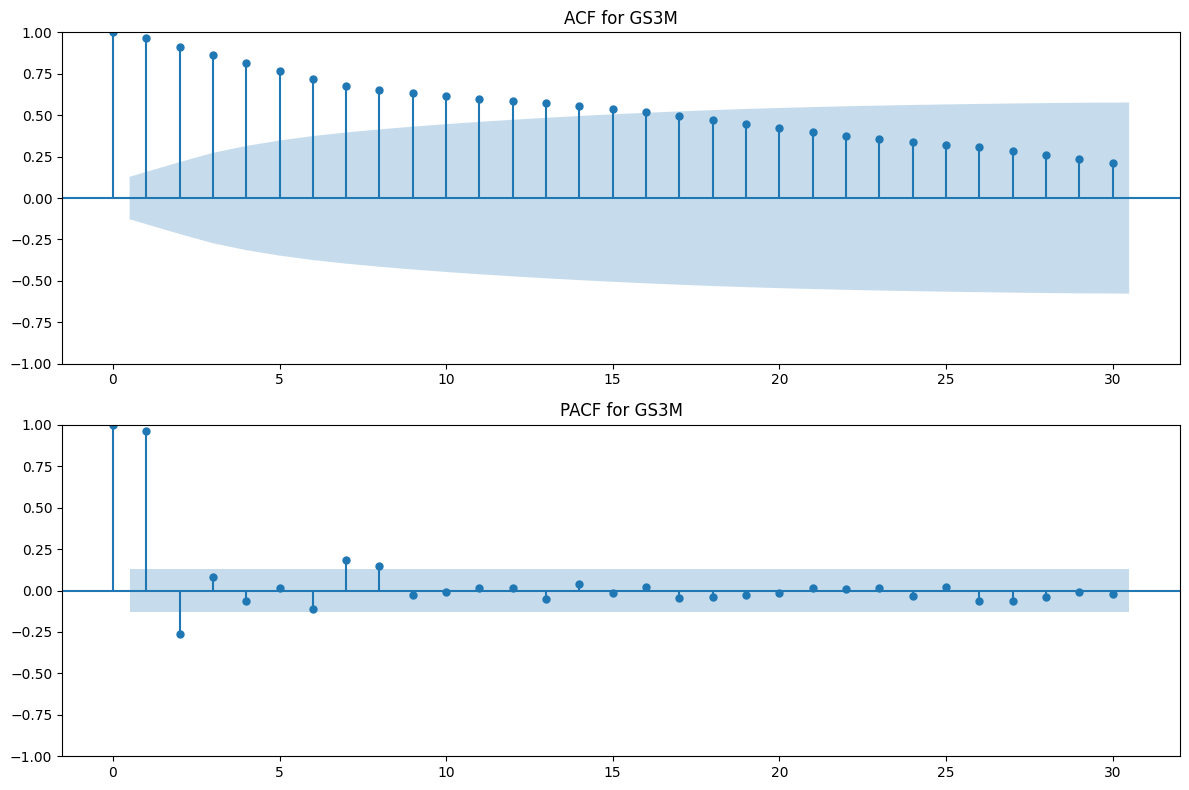


Correlogram Interpretation for GS3M:
  - ACF: Shows total correlation at each lag, including indirect effects
  - PACF: Shows direct correlation at each lag, controlling for earlier lags
  - Significant spikes outside the blue confidence interval suggest strong correlations
  - ACF decay pattern indicates potential ARIMA model orders
  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order


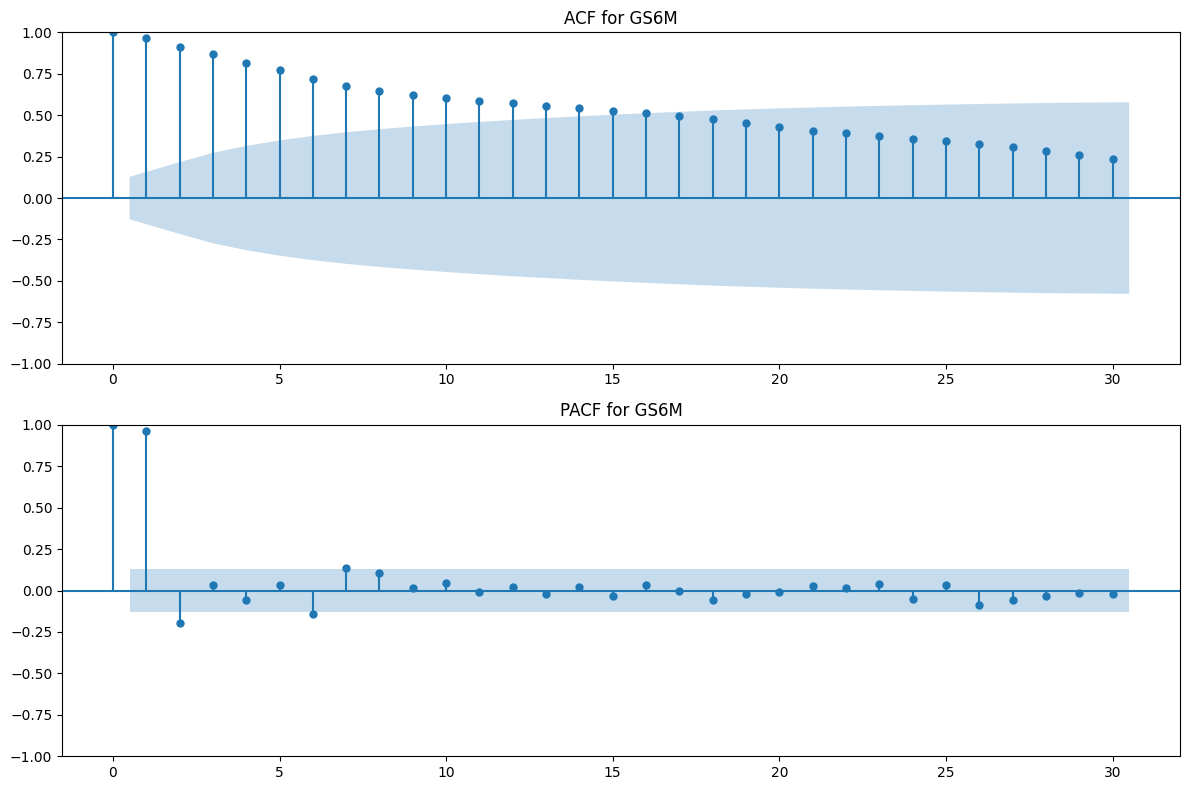


Correlogram Interpretation for GS6M:
  - ACF: Shows total correlation at each lag, including indirect effects
  - PACF: Shows direct correlation at each lag, controlling for earlier lags
  - Significant spikes outside the blue confidence interval suggest strong correlations
  - ACF decay pattern indicates potential ARIMA model orders
  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order


In [15]:
plot_correlograms(df_3, "GS3M")
plot_correlograms(df_6, "GS6M")

El análisis debe hacerse en niveles, pero en forma de VECM. Primero, las pruebas de raíz unitaria indican que al menos una de las dos tasas no es estacionaria en niveles, para la tasa a 3 meses la ADF no rechaza raíz unitaria y la KPSS rechaza estacionariedad, y para la tasa a 6 meses la ADF rechaza raíz unitaria pero la KPSS rechaza estacionariedad.

Además, los correlogramas de ambas series exhiben varios rezagos significativos, lo que es consistente con alta persistencia y con que trabajar directamente en diferencias puede borrar parte de la información de largo plazo.

Lo decisivo es que la prueba de cointegración de Johansen confirma una relación de equilibrio de largo plazo entre las dos tasas.

Por eso, no conviene estimar un VAR en primeras diferencias de ambas variables, porque se perdería la ecuación de equilibrio de largo plazo; lo correcto es estimar un VECM (un VAR en niveles con el término de corrección de error), incorporando el término que ajusta las desviaciones respecto al equilibrio. Esta especificación preserva la cointegración y modela de forma coherente la dinámica de corto plazo.